In [127]:
import ants
import os
import SimpleITK as sitk
from glob import glob
import numpy as np
from tqdm import tqdm 
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

In [128]:
ROOT_DIR = "/home/fehrdelt/bettik/"
#ROOT_DIR = "/bettik/PROJECTS/pr-gin5_aini/fehrdelt/"

In [129]:
unregistered_aini_stroke_path=ROOT_DIR+"datasets/Aini-Stroke_ADC/Others_extracted_brain/"

output_folder = ROOT_DIR+"datasets/Aini-Stroke_ADC/Others_extracted_brain_registered_resampled/"

reference_image_path = ROOT_DIR+"datasets/Dallas_ADC_rotated_resampled_registered/sub-1402_ses-wave1_ADC.nii.gz"

Reference image

(128, 128, 128)


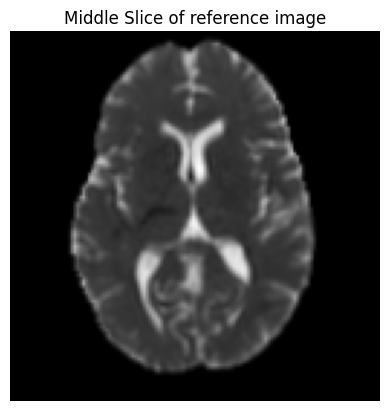

In [130]:
ref_image = nib.load(reference_image_path)
ref_image_data = ref_image.get_fdata()

print(ref_image_data.shape)
middle_slice = ref_image_data[:,:,ref_image_data.shape[2] // 2-8]

plt.imshow(middle_slice, cmap='gray')
plt.title(f"Middle Slice of reference image")
plt.axis('off')
plt.show()

aini-stroke-22082_563324_ADC_DIFF_EPI_3_NEX_ADC.nii.gz
(280, 280, 36)


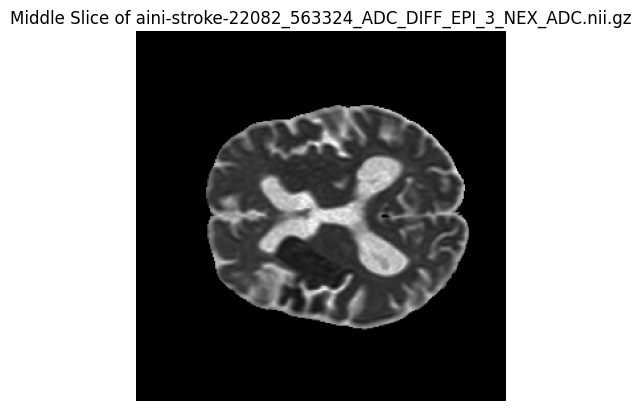

In [131]:
unregistered_filelist = os.listdir(unregistered_aini_stroke_path)

for file in unregistered_filelist:
    if "22082" in file:
        image_path = os.path.join(unregistered_aini_stroke_path, file)
        image = nib.load(image_path)
        image_data = image.get_fdata()

        print(file)
        print(image_data.shape)
        middle_slice = image_data[:,:,image_data.shape[2] // 2]

        plt.imshow(middle_slice, cmap='gray')
        plt.title(f"Middle Slice of {file}")
        plt.axis('off')
        plt.show()

In [132]:
def resample_img(itk_image, out_spacing=[1.0, 1.0, 1.0]):
    # Resample images to 2mspecified spacing with SimpleITK

    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())


    resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

In [133]:
# TODO d'abord resample en (1.0, 1.0, 1.0)

to_resample = sitk.ReadImage(unregistered_aini_stroke_path+"aini-stroke-22082_563324_ADC_DIFF_EPI_3_NEX_ADC.nii.gz")
to_resample = sitk.Cast(to_resample, sitk.sitkFloat32)

to_resample = resample_img(to_resample, out_spacing=(1.0,1.0,1.0))
sitk.WriteImage(to_resample, output_folder+"resampled_aini-stroke-22082_563324_ADC_DIFF_EPI_3_NEX_ADC.nii.gz")

In [134]:
# TODO puis rotate 90

resampled_image = nib.load(output_folder+"resampled_aini-stroke-22082_563324_ADC_DIFF_EPI_3_NEX_ADC.nii.gz")
resampled_image_data = resampled_image.get_fdata()

print(resampled_image_data.shape)

rotated_image_data = np.rot90(resampled_image_data, k=-1, axes=(0, 1))

rotated_image = nib.Nifti1Image(rotated_image_data, resampled_image.affine, resampled_image.header)
nib.save(rotated_image, output_folder+"rotated_aini-stroke-22082_563324_ADC_DIFF_EPI_3_NEX_ADC.nii.gz")




(230, 230, 158)


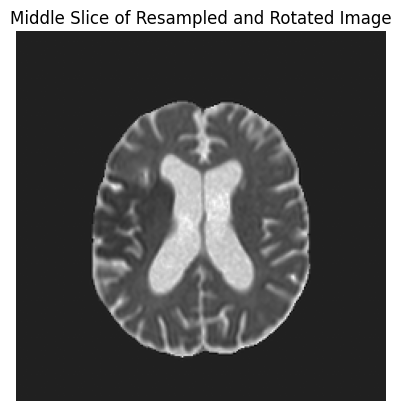

In [135]:
# Visualize the middle slice of the rotated image
middle_slice_rotated = rotated_image_data[:, :, rotated_image_data.shape[2] // 2+9]

plt.imshow(middle_slice_rotated, cmap='gray')
plt.title(f"Middle Slice of Resampled and Rotated Image")
plt.axis('off')
plt.show()

In [136]:
# Calculate the padding for each dimension
padding = [(0, 230 - rotated_image_data.shape[i]) for i in range(3)]

# Pad the rotated_image_data
padded_image_data = np.pad(rotated_image_data, padding, mode='constant', constant_values=0)

print(padded_image_data.shape)  # Should print (230, 230, 230)

(230, 230, 230)


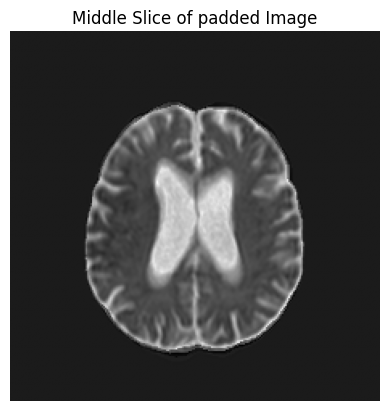

In [137]:
# Visualize the middle slice of the rotated image
middle_slice_padded = padded_image_data[:, :, padded_image_data.shape[2] // 2-20]

plt.imshow(middle_slice_padded, cmap='gray')
plt.title(f"Middle Slice of padded Image")
plt.axis('off')
plt.show()

In [142]:
# Calculate the zoom factors for each dimension
zoom_factors = [150 / padded_image_data.shape[i] for i in range(3)]

# Rescale the padded_image_data
rescaled_image_data = zoom(padded_image_data, zoom_factors, order=3)  # Using cubic interpolation

print(rescaled_image_data.shape)  # Should print (150, 150, 150)

(150, 150, 150)


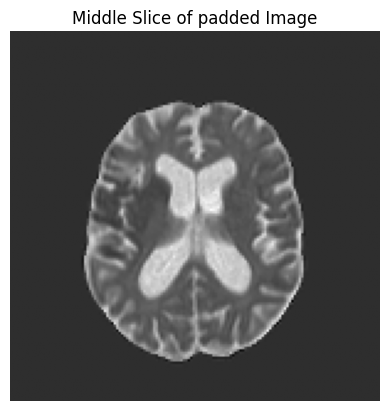

In [143]:
# Visualize the middle slice of the rotated image
middle_slice_rescaled = rescaled_image_data[:, :, rescaled_image_data.shape[2] // 2-20]

plt.imshow(middle_slice_rescaled, cmap='gray')
plt.title(f"Middle Slice of padded Image")
plt.axis('off')
plt.show()

In [144]:
# Calculate the starting indices for cropping
start_indices = [(rescaled_image_data.shape[i] - 128) // 2 for i in range(3)]

# Crop the rescaled_image_data
cropped_image_data = rescaled_image_data[
    start_indices[0]:start_indices[0] + 128,
    start_indices[1]:start_indices[1] + 128,
    start_indices[2]:start_indices[2] + 128
]

print(cropped_image_data.shape)  # Should print (128, 128, 128)

(128, 128, 128)


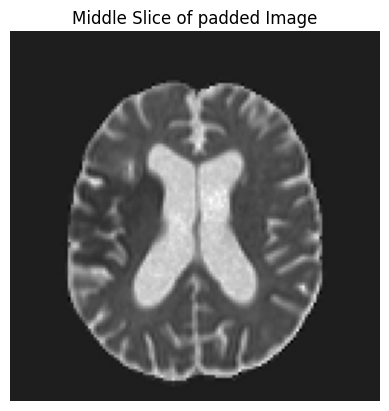

In [146]:
# Visualize the middle slice of the rotated image
middle_slice_rescaled = cropped_image_data[:, :, cropped_image_data.shape[2] // 2-18]

plt.imshow(middle_slice_rescaled, cmap='gray')
plt.title(f"Middle Slice of padded Image")
plt.axis('off')
plt.show()

In [147]:
rotated_image = nib.Nifti1Image(cropped_image_data, resampled_image.affine, resampled_image.header)
nib.save(rotated_image, output_folder+"final_aini-stroke-22082_563324_ADC_DIFF_EPI_3_NEX_ADC.nii.gz")

